# Analyzing 1-step QAOA on non-triangle-free graphs

This is heavily based on work in https://ui.adsabs.harvard.edu/abs/2018PhRvA..97b2304W/ . 

simplified to D-regular graphs with $Y$ triangles at https://www.overleaf.com/read/thgyswvpgmwt

The triangle-free case is described in their work, finding maximum angles $(\gamma, \beta) = (\arctan(1/\sqrt{D-1}), \pi/8)$. This can be proved by taking $(d\delta/d\gamma)$ and $(d\delta/d\beta)$, respectively. They also find $\delta$:

$$
\delta_{max} = (1/2)D^{-0.5}(1-1/D)^{(D-1)/2} > (1/2)D^{-0.5}e^{-0.5}
$$

The inequality follows because $\sqrt{(1-1/D)^D}$ tends towards $\sqrt{e^{-1}}$. 

---

## Finding maximum angle with triangles

I did not solve this analytically. Instead, I use a grid search over $\gamma$ and $\beta$:

In [1]:
from numpy import sin, cos, linspace, pi, e, tan
import numpy as np
import matplotlib.pyplot as plt

In [162]:
def delta_triangles(beta, gamma, D, Y):
    """This calculates delta, given a D-regular graph with Y triangles related to each edge."""
    t1 = 0.5*sin(4*beta)*sin(gamma)*(cos(gamma)**(D-1))
    t2 = 0.25*(sin(2*beta)**2)*(cos(gamma)**(2*(D-1-Y)))*(1-(cos(2*gamma)**Y))
    return t1 - t2

In [163]:
def get_max(D, Y, print_max_loc=False):
    """This searches over beta and gamma to find the optimal value of delta."""
    results = []
    for beta in linspace(0, 2*pi, 128):
        results += [delta_triangles(beta, gamma, D, Y) for gamma in linspace(0, 2*pi, 128)]
    if print_max_loc:
        maxspot = np.argmax(results)
        print("max at:", "beta=pi/8*", 8/pi*(maxspot // 128)*2*pi/128, "gamma= ", (maxspot % 128)*2*pi/128)
    return max(results)

## is there a better search?

10.6.2020

In [164]:
def print_all(D, Y, print_max_loc=False):
    """This prints all delta values for beta and gamma."""
    results = []
    for beta in linspace(0, 2*pi, 128):
        results += [delta_triangles(beta, gamma, D, Y) for gamma in linspace(0, 2*pi, 128)]
    return results

Text(0, 0.5, 'delta')

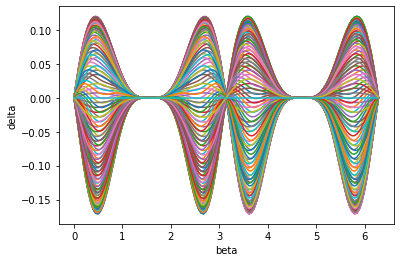

In [165]:
D=5
Y=1
x = np.reshape(print_all(D, Y), (128, -1))
for ln in x[8:]:
    plt.plot(linspace(0, 2*pi, 128), ln)
plt.xlabel("beta")
plt.ylabel("delta")

## Example usage of minimize

In [166]:
from scipy.optimize import minimize

In [167]:
def tes(x):
    return (x-0.5)**2

In [168]:
res = minimize(tes, 1, method='Powell')
res

   direc: array([[1.]])
     fun: array(0.)
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
  status: 0
 success: True
       x: array([0.5])

## Minimize by sgd

In [169]:
D=100
Y=3

In [170]:
get_max(D,Y, print_max_loc=True)

max at: beta=pi/8* 8.875 gamma=  0.09817477042468103


0.027726824455829805

just choosing gamma

In [171]:
opt_gamma = lambda x, d, y: -delta_triangles(pi/8, x, d, y)

In [172]:
res = minimize(opt_gamma, 0, method='Powell', args=(D,Y))
res

   direc: array([[0.00023117]])
     fun: array(-0.02760165)
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 2
  status: 0
 success: True
       x: array([0.10005334])

In [173]:
# this should be about D
1/sin(res.x[0])**2

100.22740646806893

choosing gamma and beta

In [174]:
opt_both = lambda x, d, y: -delta_triangles(x[0], x[1], d, y)

In [175]:
res = minimize(opt_both, (0,0), method='Nelder-Mead', args=(D,Y))
res

 final_simplex: (array([[0.36972731, 0.10003634],
       [0.36963117, 0.10006304],
       [0.36974781, 0.1001119 ]]), array([-0.02773041, -0.02773041, -0.0277304 ]))
           fun: -0.027730408069238963
       message: 'Optimization terminated successfully.'
          nfev: 114
           nit: 60
        status: 0
       success: True
             x: array([0.36972731, 0.10003634])

In [176]:
# this should be about D
1/sin(res.x[1])**2

100.2613604940141

In [177]:
def get_max_opt(D, Y):
    return -minimize(opt_both, (0,0), method='Nelder-Mead', args=(D,Y)).fun

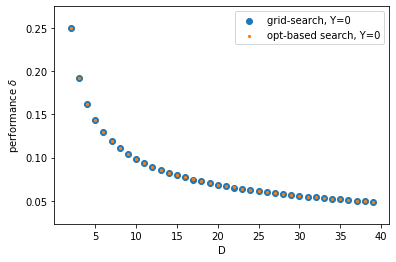

In [178]:
# This compares delta = Cuv - 1/2 from search vs the known optimal value for triangle-free graphs.
Y=0
inputs = range(2, 40)
plt.scatter(inputs, [get_max(D, Y) for D in inputs], label="grid-search, Y=0")
plt.scatter(inputs, [get_max_opt(D, Y) for D in inputs], s=5, label="opt-based search, Y=0")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()

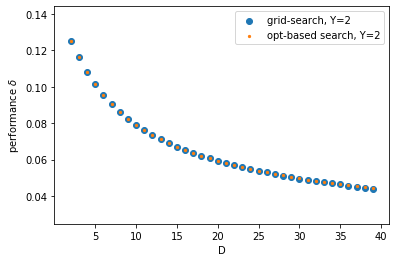

In [179]:
# This compares delta = Cuv - 1/2 from search vs the known optimal value for triangle-free graphs.
Y=2
inputs = range(2, 40)
plt.scatter(inputs, [get_max(D, Y) for D in inputs], label="grid-search, Y=" + str(Y))
plt.scatter(inputs, [get_max_opt(D, Y) for D in inputs], s=5, label="opt-based search, Y=" + str(Y))
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()

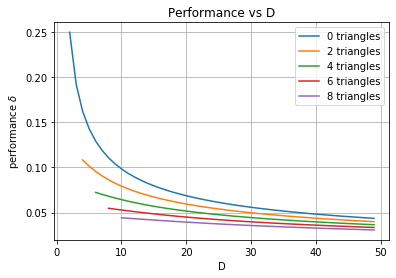

In [180]:
for Y in range(0, 10, 2):
    inputs = range(2+Y, 50)
    plt.plot(inputs, [get_max_opt(D, Y) for D in inputs], label=str(Y) + " triangles")
plt.legend()
plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.grid()

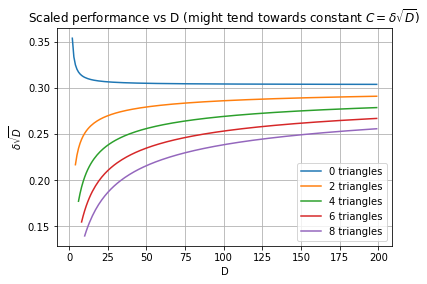

In [181]:
for Y in range(0, 10, 2):
    inputs = range(2+Y, 200)
    plt.plot(inputs, [get_max_opt(D, Y)*(D**0.5) for D in inputs], label=str(Y) + " triangles")
plt.legend()
plt.title("Scaled performance vs D (might tend towards constant $C = \delta \sqrt{D}$)")
plt.xlabel("D")
plt.ylabel("$\delta \sqrt{D}$")
plt.legend()
plt.grid(True)

### Plots

This search should match the optimal value closely for triangle-free graphs.

In [182]:
np.arctan(4**-0.5)*128/pi

18.890703059255458

In [183]:
delta_triangles( pi/8, np.arctan(4**-0.5), 5, 0)

0.14310835055998652

In [184]:
get_max(5,0, print_max_loc=True)

max at: beta=pi/8* 1.0 gamma=  2.650718801466388


0.14306860707140195

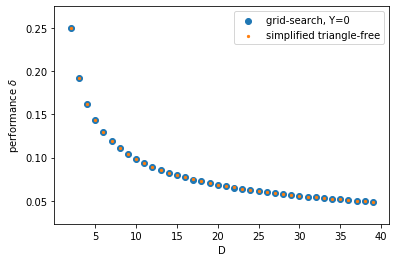

In [185]:
# This compares delta = Cuv - 1/2 from search vs the known optimal value for triangle-free graphs.
Y=0
inputs = range(2, 40)
plt.scatter(inputs, [get_max(D, Y) for D in inputs], label="grid-search, Y=0")
plt.scatter(inputs, [(1 - 1/D)**((D-1)/2) * 1/2 * D**-0.5 for D in inputs], s=5, label="simplified triangle-free")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()

How does this vary with Y? The performance gets worse with more triangles, but not by much.

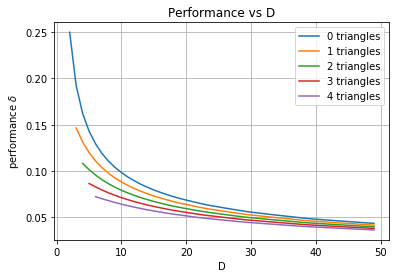

In [186]:
for Y in range(5):
    inputs = range(2+Y, 50)
    plt.plot(inputs, [get_max(D, Y) for D in inputs], label=str(Y) + " triangles")
plt.legend()
plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.grid()

In [187]:
get_max(D=3, Y=1)/(1.5)

0.09776095588159577

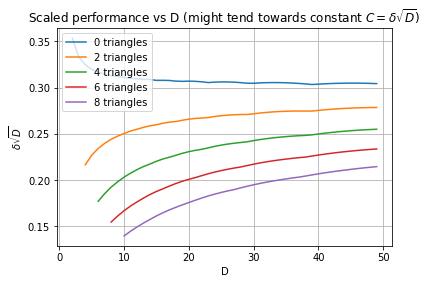

In [188]:
for Y in range(0, 10, 2):
    inputs = range(2+Y, 50)
    plt.plot(inputs, [get_max(D, Y)*(D**0.5) for D in inputs], label=str(Y) + " triangles")
plt.legend()
plt.title("Scaled performance vs D (might tend towards constant $C = \delta \sqrt{D}$)")
plt.xlabel("D")
plt.ylabel("$\delta \sqrt{D}$")
plt.legend()
plt.grid(True)

## high Y graphs

this helped me find the issue in theorem 1 of the ames paper

In [189]:
def clique_max(D):
    if D % 2 == 1:
        # even N is better
        return 1/2 + 1/(2*D)
    return 1/2 + 1/(2*(D+1))

In [190]:
D = 14
print(clique_max(D))
print(0.5 + get_max(D, D-1))

0.5333333333333333
0.5300991754936172


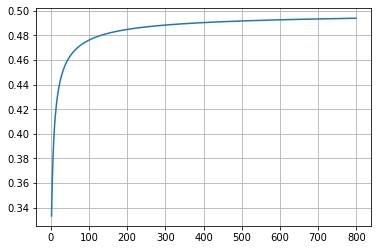

In [191]:
inps = range(2, 800)
plt.plot(inps, [get_max_opt(d, d-1)*d for d in inps])
plt.grid()
# approaches 1/2 + 1/(2D) ..

## More tests

what about Y= alpha D?

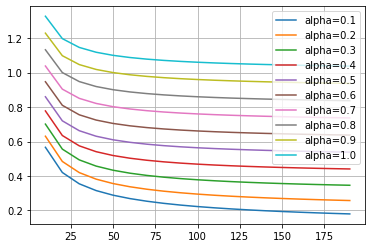

In [325]:
inps = range(10, 200, 10)
for alpha in np.linspace(0.1, 1, 10):
    plt.plot(inps, [0.5/(get_max_opt(d, int(alpha*d))*d) for d in inps], label="alpha=" +str(alpha)[:3])
plt.grid()
plt.legend()
# plt.ylim(0,1.1)
# approaches 1/2 + 1/(2 alpha D)

---

question: how do optimal gamma and beta change with y=alpha D?
might be able to answer since I think it approaches 1/2 + 1/(2 alpha D)

In [364]:
def get_gamma(alpha, D):
    Y=alpha*D
    return minimize(opt_both, (0,0), method='Nelder-Mead', args=(D,Y)).x[1]
    
def get_beta(alpha, D):
    Y=alpha*D
    return minimize(opt_both, (0,0), method='Nelder-Mead', args=(D,Y)).x[0]

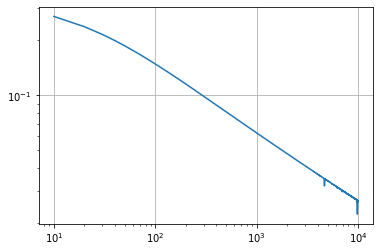

In [376]:
inps = range(10, 10000, 10)
plt.loglog(inps, [get_beta(0.5, i) for i in inps])
plt.grid()

---

# Analyzing 2-step QAOA on girth > 5 graphs

The chance of including an edge in MAXCUT can be written as 

$$
\langle C_{uv} \rangle_2 
= Tr[\rho_0 e^{i\gamma_1 C} e^{i\beta_1 J} e^{i\gamma_2 C} e^{i\beta_2 J} 
C_{uv}
e^{-i\beta_2 J} e^{-i\gamma_2 C} e^{-i\beta_1 J} e^{-i\gamma_1 C} ]
$$

with the following definitions on a graph $(V,E)$:
* $\rho_0 = \otimes_{i} (I/2 + \sigma_i^x/2) $ is the uniform superposition over all states
* $\gamma_1, \beta_1, \gamma_2, \beta_2$ are the chosen "angles"
* $C_{uv} = 1/2 - \sigma_u^z \sigma_v^z / 2$ is 1 iff the edge is cut (i.e. the nodes differ in spin)
* $C = \sum_{(u,v) \in E} C_{uv}$ is the sum of all $C_{uv}$ where there exists an edge from $u$ to $v$
* $J = \sum_{j \in V} \sigma_j^x$ is the mixing defined by QAOA

This analysis follows the approach given in Appendix A of https://ui.adsabs.harvard.edu/abs/2018PhRvA..97b2304W/ . We will assume a graph is D-regular, triangle and square and pentagon free (i.e. girth > 5).

see overleaf document for analysis

Putting all expressions together:
$$
\langle C_{uv} \rangle_2 = 1/2 - 1/2 (A + 2B + E) 
= 1/2 + c^2 rt H G^{D-1}
$$
$$
- 1/2 sc
$$
$$
\big( (1+r)(-mrH - nG)(mG - nrH)^{D-1} +
$$
$$
t(mtG^{D-1}H + in)(m + intG^{D-1}H)^{D-1} +
$$
$$
t (mtG^{D-1}H - in)(m - intG^{D-1}H)^{D-1} +
$$
$$
(1-r) (mrH - nG)(mG + nrH)^{D-1} \big)
$$
$$
- 1/2 (s^2 tH)\big((1+r)(mG - nHr)^{D-1} - (1-r)(mG + nHr)^{D-1}\big)\big( (m + inHt)^{D-1} + (m - inHt)^{D-1} \big)
$$

## Plots

In [193]:
from numpy import cos, sin, pi
import numpy as np
import functools

In [194]:
@functools.lru_cache()
def qaoa2(beta_2, gamma_2, beta_1, gamma_1, D):
    c = cos(2*beta_2)
    s = sin(2*beta_2)
    m = cos(gamma_2)
    n = sin(gamma_2)
    r = cos(2*beta_1)
    t = sin(2*beta_1)
    G = cos(gamma_1)
    H = sin(gamma_1)

    A = -2*c*c*r*t*H*(G**(D-1))
    bpt1 =  0.5*s*c*(  (1 + r)*(-m*r*H - n*G)*((m*G - n*r*H)**(D-1)) + (1 - r)*(m*r*H - n*G)*((m*G + n*r*H)**(D-1))  )
    bpt2 = 0.5*s*c*t*(  (m*t*(G**(D-1))*H + (1j)*n)*((m + (1j)*n*t*(G**(D-1))*H)**(D-1)) + (m*t*(G**(D-1))*H - (1j)*n)*((m - (1j)*n*t*(G**(D-1))*H)**(D-1)) )
    Ea =  s*s*t*H * 0.5 *( (1+r)*(m*G - n*H*r)**(D-1) - (1-r)*(m*G + n*H*r)**(D-1))
    Eb = (m + (1j)*n*H*t)**(D-1) + (m - (1j)*n*H*t)**(D-1)
    return 0.5 - 0.5 * (A + 2*(bpt1 + bpt2) + Ea*Eb)

In [195]:
# verify number is real and in bounds
grid_size = 16
for D in range(2, 10):
    print(D)
    for beta_2 in np.array(range(grid_size))*(pi/grid_size):
        for gamma_2 in np.array(range(grid_size))*(2*pi/grid_size):
            for beta_1 in np.array(range(grid_size))*(pi/grid_size):
                for gamma_1 in np.array(range(grid_size))*(2*pi/grid_size):
                        result = qaoa2(beta_2, gamma_2, beta_1, gamma_1, D)
        
                        assert 0 == result.imag, (result.real, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)
                        assert 0 <= result.real, (result.real, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)
                        assert 1 >= result.real, (result.real, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)

2
3
4
5
6
7
8
9


In [196]:
@functools.lru_cache()
def find_max_qaoa2(D, grid_size):
    """
    Finds maximum value of QAOA performance.
    Should be real number between -1 and 1.
    This runtime of this method is O(grid_size^4).
    """
    maxval = -np.inf
    for beta_2 in np.array(range(grid_size))*(pi/grid_size):
        for gamma_2 in np.array(range(grid_size))*(2*pi/grid_size):
            for beta_1 in np.array(range(grid_size))*(pi/grid_size):
                for gamma_1 in np.array(range(grid_size))*(2*pi/grid_size):
                        result = qaoa2(beta_2, gamma_2, beta_1, gamma_1, D)
                        assert 0 == result.imag, (result.real, beta_2, gamma_2, beta_1, gamma_1, D)
                        assert 0 <= result.real, (result.real, beta_2, gamma_2, beta_1, gamma_1, D)
                        assert 1 >= result.real, (result.real, beta_2, gamma_2, beta_1, gamma_1, D)
                        maxval = max(maxval, result.real)
    return maxval

In [197]:
find_max_qaoa2(2, 20)

0.8320312500000002

In [198]:
find_max_qaoa2(4, 20)

0.7064695365955405

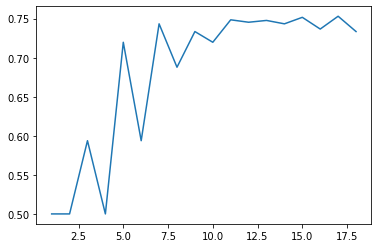

In [199]:
plt.plot(range(1, 19), [find_max_qaoa2(3, i) for i in range(1, 19)])

## Testing against D=2 formula

In [200]:
find_max_qaoa2(2, 10)

0.8320312500000002

In [201]:
def appendixc(beta_2, gamma_2_input, beta_1, gamma_1_input):
    """
    inputs use regular definition of gamma
    """
    gamma_1 = -gamma_1_input/2
    gamma_2 = -gamma_2_input/2
    return 1/64 * ( \
        -7*cos(4*beta_1 + 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_1 + 4*beta_2 + 4*gamma_1)
                   
        +3*cos(4*beta_1 + 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(4*beta_1 + 4*beta_2 + 4*gamma_2)
                   
        +3*cos(4*beta_1 - 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_1 - 4*beta_2 + 4*gamma_1)
                   
        -3*cos(4*beta_1 - 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(4*beta_1 + 4*gamma_1 + 4*gamma_2)
                   
        -4*cos(4*beta_1 + 4*gamma_1)
        -4*cos(4*beta_1 + 4*gamma_2)
        -3*cos(-4*beta_1 + 4*beta_2 + 4*gamma_1 + 4*gamma_2)
                   
        +6*cos(-4*beta_1 + 4*beta_2 + 4*gamma_1)
        +3*cos(-4*beta_1 + 4*beta_2 - 4*gamma_1 + 4*gamma_2)
                   
        +7*cos(-4*beta_1 - 4*beta_2 + 4*gamma_1 + 4*gamma_2)
        +6*cos(-4*beta_1 - 4*beta_2 + 4*gamma_1)
                   
        -3*cos(-4*beta_1 - 4*beta_2 - 4*gamma_1 + 4*gamma_2)
        -4*cos(-4*beta_1 - 4*beta_2 + 4*gamma_2)
                   
        -4*cos(-4*beta_1 + 4*gamma_1 + 4*gamma_2)
        +4*cos(-4*beta_1 + 4*gamma_1)
        +4*cos(-4*beta_1 + 4*gamma_2)
                   
        -6*cos(4*beta_2 + 4*gamma_1 + 4*gamma_2)
        -6*cos(4*beta_2 - 4*gamma_1 + 4*gamma_2)
        -4*cos(4*beta_2 + 4*gamma_2)
                   
        +6*cos(-4*beta_2 + 4*gamma_1 + 4*gamma_2)
        +6*cos(-4*beta_2 - 4*gamma_1 + 4*gamma_2)
        +4*cos(-4*beta_2 + 4*gamma_2)
                  )

 need to convert problem to: 1/2 - 1/2 appendixc
 
with gamma -> -2gamma

In [202]:
0.5 - 0.5*appendixc(1, 1, 1, 1)

0.33508746221506275

should approach 5/6

In [203]:
grid_size = 10 # 30
max([0.5 - 0.5*appendixc(i,j,k,l) for i in np.linspace(0, 2*pi, grid_size) for j in np.linspace(0, 2*pi, grid_size) for k in np.linspace(0, 2*pi, grid_size) for l in np.linspace(0, 2*pi, grid_size)])

0.8197116039655878

In [204]:
# verify number is in bounds
grid_size = 20
for beta_2 in np.array(range(grid_size))*(pi/grid_size):
    for gamma_2 in np.array(range(grid_size))*(2*pi/grid_size):
        for beta_1 in np.array(range(grid_size))*(pi/grid_size):
            for gamma_1 in np.array(range(grid_size))*(2*pi/grid_size):
                    result = 0.5-0.5*appendixc(beta_2, gamma_2, beta_1, gamma_1)
                    assert 0 <= result, (result, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)
                    assert 1 >= result, (result, beta_2/pi, gamma_2/pi, beta_1/pi, gamma_1/pi, D)

In [205]:
def appendixcsimplified(beta_1, gamma_1):
    """
    using wang definition of gamma_1
    """
    return 1/64 * ( \
                    -2*cos(8*beta_1)
                    + 3*cos(8*beta_1 + 8*gamma_1)
                    - 12*cos(4*beta_1 + 8*gamma_1)
                   -8*cos(4*beta_1 + 4*gamma_1)
                   + 12*cos(4*beta_1 - 8*gamma_1)
                   + 8*cos(4*beta_1 - 4*gamma_1)
                   + 7*cos(8*beta_1 - 8*gamma_1)
                   - 8*cos(8*beta_1 - 4*gamma_1)
                   + 6*cos(8*gamma_1)
                   + 8*cos(4*gamma_1)
                   - 14
            )

In [206]:
0.5-0.5*appendixcsimplified(.1026, .2052)

0.5130872205816883

I'm not sure about this simplified form... unless calculating maximum

## maximum matches

In [207]:
grid_size = 100 #300
max([0.5 - 0.5*appendixcsimplified(i,j) for i in np.linspace(0, 2*pi, grid_size) for j in np.linspace(0, 2*pi, grid_size) ])

0.8331456078533599

## comparison plots

In [208]:
import matplotlib.pyplot as plt

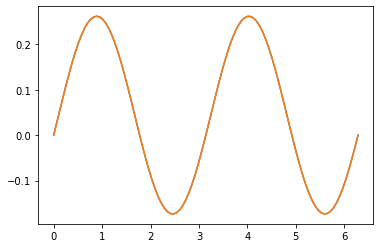

In [209]:
gamma_2s = np.linspace(0, 2*pi, 100)
plt.plot(gamma_2s, [-0.5*appendixc(pi/8, g, pi/8, pi/8) for g in gamma_2s])
plt.plot(gamma_2s, [qaoa2(pi/8, g, pi/8, pi/8, 2).real-0.5 for g in gamma_2s])

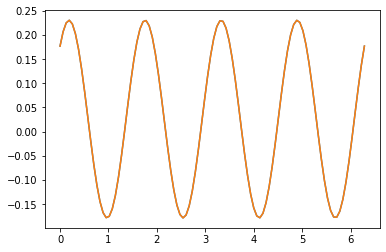

In [210]:
beta_2s = np.linspace(0, 2*pi, 100)
plt.plot(beta_2s, [-0.5*appendixc(b, pi/8, pi/8, pi/8) for b in beta_2s])
plt.plot(beta_2s, [qaoa2(b, pi/8, pi/8, pi/8, 2).real-0.5 for b in beta_2s])

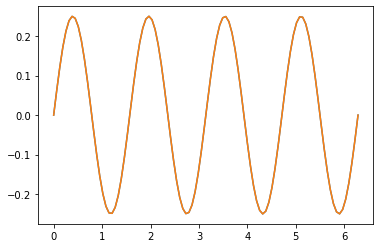

In [211]:
beta_1s = np.linspace(0, 2*pi, 100)
plt.plot(beta_1s, [-0.5*appendixc(0, 0, b, pi/4) for b in beta_1s])
plt.plot(beta_1s, [qaoa2(0, 0, b, pi/4, 2).real-0.5 for b in beta_1s])

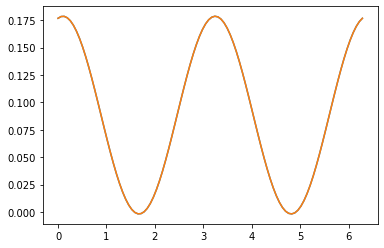

In [212]:
gamma_1s = np.linspace(0, 2*pi, 100)
plt.plot(gamma_1s, [-0.5*appendixc(pi/8, pi/8, pi/8, g) for g in gamma_1s])
plt.plot(gamma_1s, [qaoa2(pi/8, pi/8, pi/8, g, 2).real-0.5 for g in gamma_1s])

In [213]:
def f(a, b, c, d):
    return qaoa2(a,b,c,d, 2).real-0.5+0.5*appendixc(a, b, c, d)

In [214]:
import random

###  it matches basically all the time

In [215]:
vals = []
for _ in range(100000):
    vals.append(f(2*pi*random.random(), 2*pi*random.random(), 2*pi*random.random(), 2*pi*random.random()))

(array([1.0000e+01, 1.1700e+02, 8.8200e+02, 6.9450e+03, 3.9531e+04,
        4.4431e+04, 7.0310e+03, 9.3100e+02, 1.0600e+02, 1.6000e+01]),
 array([-1.49880108e-15, -1.20008170e-15, -9.01362318e-16, -6.02642936e-16,
        -3.03923553e-16, -5.20417043e-18,  2.93515212e-16,  5.92234595e-16,
         8.90953977e-16,  1.18967336e-15,  1.48839274e-15]),
 <a list of 10 Patch objects>)

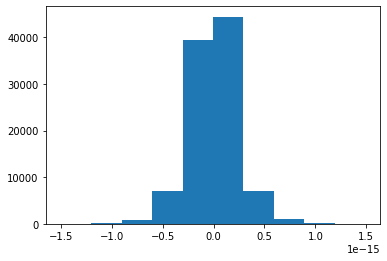

In [216]:
plt.hist(vals)

## Qaoa 2 formula (both appendix c and mine) collapses to qaoa1 formula if beta_1 = 0, gamma_1 = 0 or beta_2, gamma_2 = 0,0

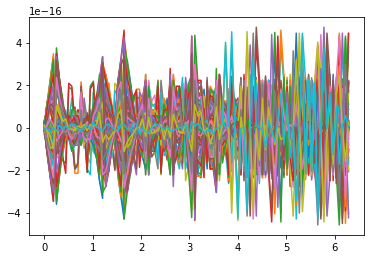

In [217]:
# works ok for ring formula
for b in beta_1s:
    plt.plot(gamma_1s, [delta_triangles(b, g, 2, 0)- (-0.5*appendixc(b, g, 0, 0)) for g in gamma_1s], label="beta_1=" + str(b))

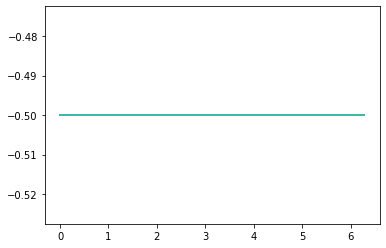

In [218]:
for b in beta_1s:
    plt.plot(gamma_1s, [delta_triangles(b, g, 2, 0)-qaoa2(b, g, 0, 0, 2).real for g in gamma_1s], label="beta_1=" + str(b))

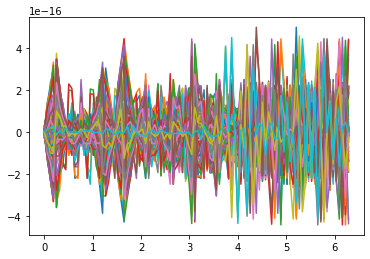

In [219]:
# works ok for ring formula
for b in beta_1s:
    plt.plot(gamma_1s, [delta_triangles(b, g, 2, 0)- (-0.5*appendixc(0, 0, b, g)) for g in gamma_1s], label="beta_1=" + str(b))

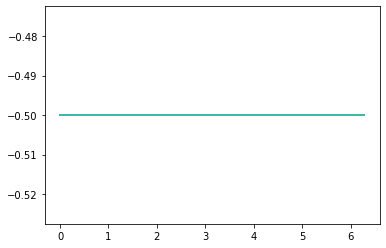

In [220]:
for b in beta_1s:
    plt.plot(gamma_1s, [delta_triangles(b, g, 2, 0)-qaoa2(0, 0, b, g, 2).real for g in gamma_1s], label="beta_1=" + str(b))

# TODO  from here
* replace i idx variable in eqwuations with j or some4thing else
* doits with \cdots
* need new variable name for D -> E

Need to code this expression up, and plot across the 8 variables...

## todo - Optimizations
* Memoize results in cuv triangles so it only takes a long time to run once


## todo - Analytical result
* Could try to solve optimal value analytically for f=1, or f=2, etc?
* Could try to solve optimal value generally for f?

$$
〈Cuv〉(d,f)  =1/2+1/2sin 4βsinγ(cos^dγ)−1/4sin^2βcos^{2(d−f)}γ(1−cos^f2γ)
$$

$$
〈Cuv〉(d,f)  =1/2+1/2sin 4βsinγ(cos^dγ)−1/4sin^2βcos^{2(d−f)}γ(1−cos^f2γ)
$$


## todo - Comparison with Hastings + triangles
started july 10
* it looks like Hastings does worse with many triangles, or at least takes a high D to catch up. Verify this. Why might this be?
* one triangle to one triangle, Hastings catches up by D=20-30.
* two triangles to two triangles, Hastings catches up by D=60-75.
* maybe, in limit of D, Hastings will win, but with many triangles, Hastings algorithm is not that good?
    * it makes sense. Hastings depends on the $E_{ij}$ having an impact on modifying $i$ but not $j$, or vice versa. If many neighbors are shared, it limits the impact of $E_{ij}$ being in the max cut (i.e. $i$ and $j$ being differently colored).

In [221]:
# if beta = pi/8, then the last term has this much we ight compared to the triangle-free term
sin(pi/8)**2/2

0.07322330470336312

In [222]:
def test(x, d, f):
    """something to find the max of"""
    return sin(x) * cos(x)**d - .073* cos(x)**(2*d-2*f) * (1 - cos(2*x)**f)

0.15407211396280857 cot^2(gamma): 15.034609765779608
0.1503758142939567 cot^2(gamma): 15.034609765779608
0.14668016666400788 cot^2(gamma): 15.130442693719809
0.14296930832566226 cot^2(gamma): 15.130442693719809
0.13922845634952807 cot^2(gamma): 15.227156491516158
0.13544356248562403 cot^2(gamma): 15.42327015835377
0.1316021187021014 cot^2(gamma): 15.623039376023863
0.127695432523486 cot^2(gamma): 15.826555523267764
0.12371926542290256 cot^2(gamma): 16.245208598052272
0.1196756002129015 cot^2(gamma): 16.68001988102886
0.11557503917375125 cot^2(gamma): 17.364390380878994
0.11143694061245829 cot^2(gamma): 18.215310855763693
0.10728986831771681 cot^2(gamma): 19.26372604340221
0.103168733504168 cot^2(gamma): 20.551116496977574
0.09911159426621666 cot^2(gamma): 21.96746648471558


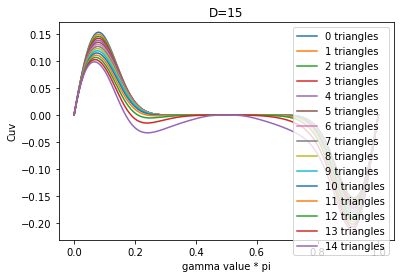

In [223]:
d=15
for f in range(d):
    inputs = np.linspace(0,pi, 4096)
    outputs = [test(x, d, f) for x in inputs]
    plt.plot(inputs/pi, outputs, label=str(f) + " triangles")
    print(max(outputs), "cot^2(gamma):", np.tan(inputs[outputs.index(max(outputs))])**-2)
plt.xlabel("gamma value * pi")
plt.ylabel("Cuv")
plt.title('D=' + str(d))
plt.legend()

Assuming Beta = pi/8, the maximum gamma value does not change by much, but it does get slightly less with more triangles.

## comparing QAOA 2 with Hastings

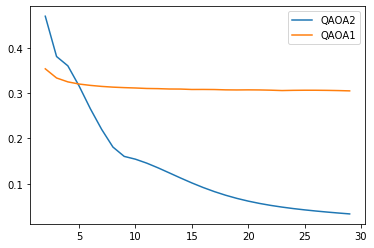

In [224]:
grid_val = 10
x = range(2, 30)
plt.plot(x, [i**0.5*(find_max_qaoa2(i, grid_val)-0.5) for i in x], label="QAOA2")
plt.plot(x, [i**0.5*get_max(i,0) for i in x], label="QAOA1")
plt.legend()

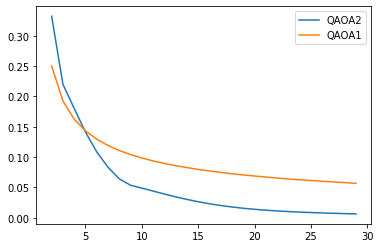

In [225]:
grid_val = 10
x = range(2, 30)
plt.plot(x, [find_max_qaoa2(i, grid_val)-0.5 for i in x], label="QAOA2")
plt.plot(x, [get_max(i,0) for i in x], label="QAOA1")
plt.legend()

I'm worried the numerical grid search isn't enough.

## ANALYSIS on graphs with triangles, p=1, $\alpha (D-1)$ triangles

$$
\langle C_{uv} \rangle = 1/2 + (1/2)sin(4\beta)sin(\gamma)cos^{D-1}(\gamma) - (1/4)sin^2(\beta)cos^{2(D-1-Y)}(\gamma)(1-cos^Y(2\gamma))
$$

so modifier term is $1/2 sin(4\beta) sin(\gamma) cos^{D-1}(\gamma) - 1/4 sin^2(\beta) cos^{2(1-\alpha)(D-1)}(\gamma) (1 - cos^{\alpha (D-1)}(2\gamma))$

In [226]:
sin(pi/8)

0.3826834323650898

In [227]:
(sin(pi/8)*sin(pi/8))**-0.5

2.613125929752753

In [228]:
fx = lambda b,g,D,Y: 0.5*sin(4*b)*sin(g)*cos(g)**(D-1) - 0.25*sin(b)**2 * cos(g)**(2*(D-1-Y)) * (1 - cos(2*g)**Y)

In [229]:
fx(100, 100, 4, 1)

0.11996617471025732

In [230]:
D=100
Y=0
fxd = lambda b,g: fx(b,g,D,Y)

1. make a 3d plot
2. optimize in that area (look for a scipy or numpy package)?

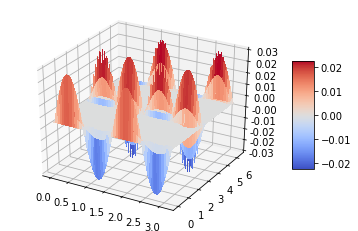

In [231]:
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
b = np.linspace(0, pi, 100)
g = np.linspace(0, 2*pi, 100)

b, g = np.meshgrid(b, g)
Z = fxd(b, g)


# Plot the surface.
surf = ax.plot_surface(b, g, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


## opt based qaoa2

In [276]:
qaoa_opt = lambda x,D: -qaoa2(x[0],x[1],x[2],x[3],D)

In [277]:
D=25
minimize(qaoa_opt, (pi/4,pi/4,pi/4,pi/4), args=(D,))

      fun: (-0.5-0j)
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 1.43051147e-06,  0.00000000e+00, -3.72529030e-08,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.78539816, 0.78539816, 0.78539816, 0.78539816])

In [321]:
def find_max_qaoa2_opt(D):
    #more local minima to get stuck in...
    return minimize(qaoa_opt, (pi/4,pi/4,pi/4,pi/4), method='Powell', args=(D,)).fun

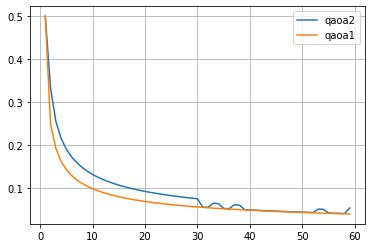

In [322]:
inps = range(1, 60)
plt.plot(inps, [-find_max_qaoa2_opt(i)-0.5 for i in inps], label="qaoa2")
plt.plot(inps, [get_max_opt(i, 0) for i in inps], label="qaoa1")
plt.grid()
plt.legend()

---

trying to analytically optimize Y=alpha D qaoa1.

let's look at sin(4b) A - sin^2 2b (B)

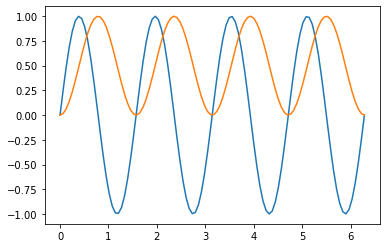

In [378]:
inps = np.linspace(0, 2*pi, 100)
plt.plot(inps, sin(4*inps))
plt.plot(inps, sin(2*inps)**2)

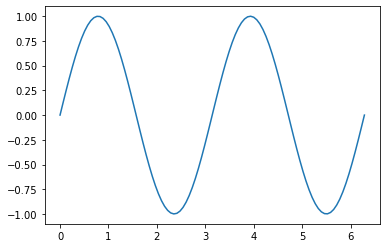

In [399]:
inps = np.linspace(0, 2*pi, 100)
plt.plot(inps, sin(2*inps))

# goal: analytic description of max of qaoa1

In [268]:
def f(g, D, Y):
    A = cos(g)**(D-1) * sin(g)
    B = 0.5 * cos(g)**(2*(D-1-Y)) * (1 - cos(2*g)**Y)
    h2 = 4*A*A + B*B
    return  0.5 * (h2**0.5 - B), A, B

In [269]:
inps = np.linspace(0, pi/2, 100)[1:-1]
af = lambda g, D, Y: cos(g)**(D-1) * sin(g)
bf  = lambda g, D, Y: 0.5 * cos(g)**(2*(D-1-Y)) * (1 - cos(2*g)**Y)

/home/kunal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


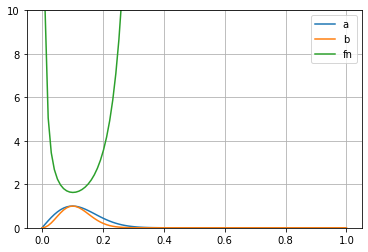

In [329]:
D=100
Y=10
inps = np.linspace(0, 1, 100)
a = [af(i, D, Y) for i in inps]
b = [bf(i, D, Y) for i in inps]
o = [af(i, D, Y)/bf(i,D,Y) for i in inps]
plt.plot(inps, a/max(a), label='a')
plt.plot(inps, b/max(b), label='b')
plt.plot(inps, o, label='fn')
plt.ylim(0,10)
plt.legend()
plt.grid()

Y=0 gamma: 0.10502143290777828
Y=0.0
delta: 0.031878564167764904
gamma: 0.10487687403206736
beta: 1.5707963267948966
Y=45.0
delta: 0.009751904991750472
gamma: 0.08445141541908045
beta: 1.3149662168641538
Y=90.0
delta: 0.0052163788532921945
gamma: 0.057741200309789895
beta: 2.1282320383295077e-09


/home/kunal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


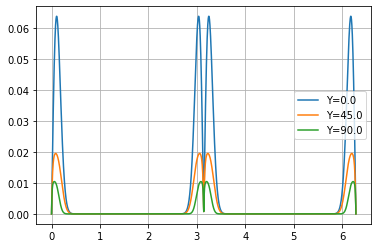

In [271]:
D=91
print("Y=0 gamma:", (np.arctan((D-1)**-0.5)))
for Y in np.linspace(0, D-1, 3):
    inps = np.linspace(0, 2*pi, 4000)
    res = [f(i, D, Y)[0] for i in inps]
    plt.plot(inps, res, label="Y=" + str(Y))
    inps = np.linspace(0, pi/2, 4000)
    res = [f(i, D, Y)[0] for i in inps]
    print("Y=" + str(Y))
    print("delta:",max(res)/2)
    print("gamma:", inps[np.argmax(res)]) #todo
    print("beta:", np.arctan(f(np.argmax(res), D, Y)[1] * 2 /  f(np.argmax(res), D, Y)[2] ))
plt.grid()
plt.legend()

0.7853981633974483
0.4636476090008061
0.3217505543966422
0.18360401027891857
0.1418970546041639
0.1001674211615598
0.07076973666221362
0.03162804943757168


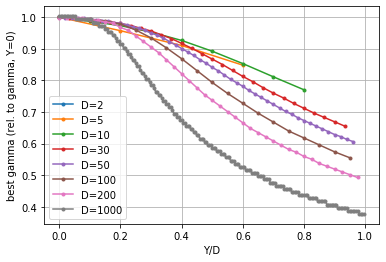

In [272]:
for D in [2, 5, 10, 30, 50, 100, 200, 1000]:
    y0gamma = np.arctan((D-1)**-0.5)
    print(y0gamma)
    ys = range(0, D-1)[::(5 if D > 50 else 1)]
    inps = np.linspace(0,pi/2, 5000)
    plt.plot(np.array(ys)/D, [ inps[np.argmax([f(i, D, Y)[0] for i in inps])] / y0gamma for Y in ys], '.-', label="D=" + str(D))
plt.xlabel("Y/D")
plt.ylabel("best gamma (rel. to gamma, Y=0)")
plt.grid()
plt.legend()

so gamma always decreases when adding triangles!!

gamma will get close to zero when D or Y get large

trying to find D=Y-1 max

Y=0 gamma 0.1001674211615598
delta: 0.004761868707073229
gamma: 0.05436042499210184
beta: 0.08863412213408119


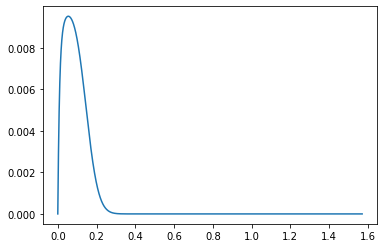

In [273]:
D=100
Y=D-1
print("Y=0 gamma", (np.arctan((D-1)**-0.5)))
inps = np.linspace(0,pi/2, 5000)
res = [f(i, D, Y)[0] for i in inps]
plt.plot(inps, res)
print("delta:",max(res)/2)
print("gamma:", inps[np.argmax(res)]) #todo
print("beta:", np.arctan(f(np.argmax(res), D, Y)[1] * 2 /  f(np.argmax(res), D, Y)[2] ))

### does max gamma of clique follow a pattern?

Text(0, 0.5, 'gamma value')

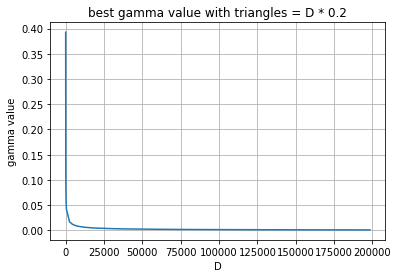

In [274]:
alpha = 0.2
ds = list(range(5, 500, 5)) + list(range(500, 200000, 2000))
gs = []
for D in ds:
    Y = int(alpha*D)
    inps = np.linspace(0,pi/8, 5000)
    res = [f(i, D, Y)[0] for i in inps]
    g = inps[np.argmax(res)]
    gs.append(g)
plt.plot(ds, gs)
plt.grid(which='both')
plt.title("best gamma value with triangles = D * " + str(alpha))
plt.xlabel("D")
plt.ylabel("gamma value")

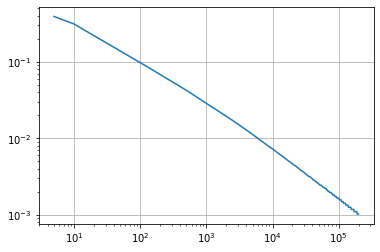

In [275]:
plt.loglog(ds, gs)
plt.grid()

In [276]:
a = ds[sum(np.array(gs) > .02)]

In [277]:
b = ds[sum(np.array(gs) > .002)]

In [278]:
# approaches 2/3?
np.log(0.1)/np.log(b/a)

-0.683808375993889

### testing B' is positive or not

In [279]:
fn = lambda D, y, c: D-1-y - y*c**(y-1) - (D-1)*c**y

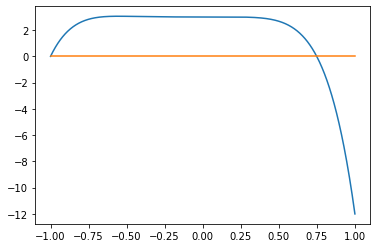

In [281]:
D=10
Y=6
inps = np.linspace(-1,1,1000)
plt.plot(inps, [fn(D,Y,i) for i in inps])
plt.plot(inps, [0]*len(inps))

---


In [287]:
f = lambda k: (1+k*k)**0.5 - k
f2 = lambda k: 3/(8*k)

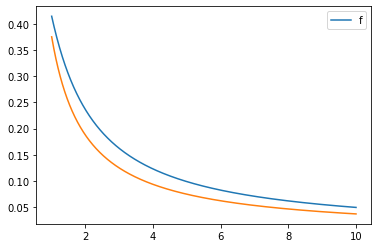

In [288]:
inps = np.linspace(1,10,1000)
plt.plot(inps, f(inps), label='f')
plt.plot(inps, f2(inps))
plt.legend()

### x/sinh(x)

In [289]:
ex = lambda c: 2*c - (e**c - e**(-c))

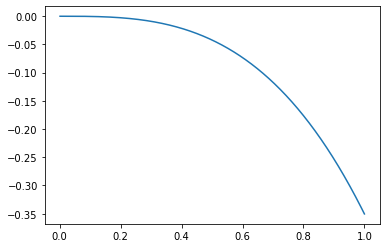

In [290]:
inps = np.linspace(.001, 1, 1000)
plt.plot(inps, ex(inps))